# IFT603 - Devoir 4

* Classifieur linéaire avec un réseau de neurones à une couche
* Fonction de perte: entropie-croisée
* Descente de gradient
* Recherche d'hyperparamètres
* Visualisation des résultats

# Configuration

In [5]:
'''
 Imporation des bibliothèques python générales
'''
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.datasets import make_classification

'''
 Imporation des bibliothèques spécifiques au devoir
'''
import utils
from linear_classifier import LinearClassifier
from two_layer_classifier import TwoLayerClassifier

%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1ère partie du devoir : la classification linéaire par régression logistique

**Préparation des données**

Nous utilisons une fonction bien connue de sklearn pour générer un jeu de données nommée [make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).  Cette base de données comprend 1000 éléments distribués dans 3 classes.

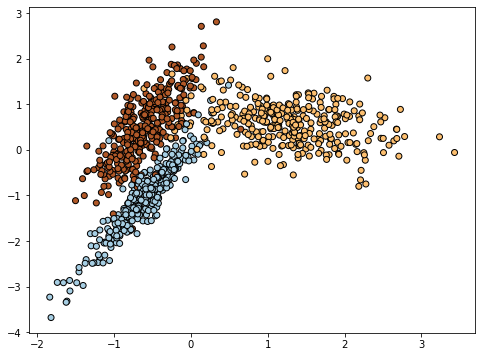

In [6]:
# Générer des données
X_, y_ = make_classification(1000,n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1, n_classes=3,random_state=6)

# Centrer et réduire les données (moyenne = 0, écart-type = 1)
mean = np.mean(X_, axis=0)
std = np.std(X_, axis=0)
X_ = (X_ - mean) / std

# Afficher
plt.figure(figsize=(8, 6))
plt.scatter(X_[:, 0], X_[:, 1], c=y_, edgecolors='k', cmap=plt.cm.Paired)
plt.show()

Séparons le jeu de données en trois parties: l'ensemble **d'entraînement**, de **validation** et de **test** (_train_, _val_ et _test_).

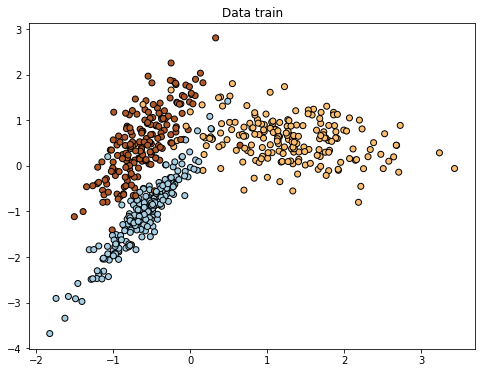

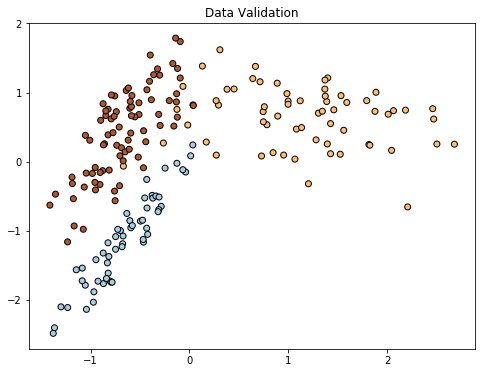

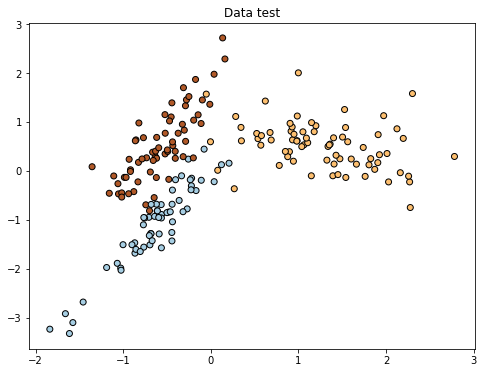

In [7]:
num_val = 200
num_test = 200
num_train = 600
np.random.seed(1)
idx = np.random.permutation(len(X_))

train_idx = idx[:num_train]
val_idx = idx[num_train:num_train + num_val]
test_idx = idx[-num_test:]

X_train = X_[train_idx]
y_train = y_[train_idx]
X_val = X_[val_idx]
y_val = y_[val_idx]
X_test = X_[test_idx]
y_test = y_[test_idx]

# Afficher
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Data train')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Data Validation')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Data test')
plt.show()

Vérifions que les données sont valides en entraînant un SVM de la librairie `scikit-learn`.

In [8]:
accu = utils.test_sklearn_svm(X_train, y_train, X_test, y_test)
print('Test accuracy: {:.3f}'.format(accu))
if accu < 0.7:
    print('ERREUR: L\'accuracy est trop faible. Il y a un problème avec les données. Vous pouvez essayer de refaire le mélange (case ci-haut).')

Test accuracy: 0.950


# Implémenter un classifieur logistique linéaire

Dans `linear_classifer.py`, implémenter la `cross_entropy_loss` (entropie croisée) ainsi que les méthodes avec l'indicatif TODO

Une fois fait, vérifier votre implémentation avec les cases qui suivent.

Commençons par quelques **Sanity Checks**

In [22]:
# En premier, vérifier la prédiction du modèle, la "forward pass"
# 1. Générer le modèle avec des poids W aléatoires
model = LinearClassifier(X_train, y_train, X_val, y_val, num_classes=3, bias=True)

# 2. Appeler la fonction qui calcule l'accuracy et la loss moyenne pour l'ensemble des données d'entraînement
_, loss = model.global_accuracy_and_cross_entropy_loss(X_train,y_train)

# 3. Comparer au résultat attendu
loss_attendu = -np.log(1.0/3.0) # résultat aléatoire attendu soit -log(1/nb_classes)
print('Sortie: {}  Attendu: {}'.format(loss, loss_attendu))
if abs(loss - loss_attendu) > 0.05:
    print('ERREUR: la sortie de la fonction est incorrecte.')
else:
    print('SUCCÈS')

Sortie: 1.100776517308367  Attendu: 1.0986122886681098
SUCCÈS


W = [[ 0.0120415  -0.00776319  0.00608427]
 [-0.01310983 -0.00436019 -0.00472292]
 [-0.00198968  0.00292126 -0.00092096]]
x = [0.63714205 0.67788111 1.        ]
y_n = [-0.00320445 -0.00498069 -0.000246  ]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [0.33320137 0.33261005 0.33418859]
loss = 1.1007845103154914
dW = [[ 0.2122966   0.22587091  0.33320137]
 [-0.4252222  -0.45241105 -0.66738995]
 [ 0.2129256   0.22654013  0.33418859]] 
--------
W = [[-0.2002551  -0.23363411 -0.3271171 ]
 [ 0.41211237  0.44805085  0.66266704]
 [-0.21491529 -0.22361887 -0.33510955]]
x = [0.26669239 0.63932783 1.        ]
y_n = [-0.00484689  0.00052406  0.00131228]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [0.33205342 0.33384167 0.33410491]
loss = 1.0970884524668891
dW = [[ 0.08855612  0.21229099  0.33205342]
 [-0.17765936 -0.42589356 -0.66615833]
 [ 0.08910324  0.21360257  0.33410491]] 
--------
W = [[-0.28881122 -0.4459251  -0.65917052]
 [ 0.58977173  0.87394441  1.32882537]
 [-0.30401852 -0.43722144 -0.66921446]]
x = 

--------
W = [[-0.5371573  -0.66007108 -0.82866093]
 [ 2.07640737  1.25193188  1.31819163]
 [-1.54230808 -0.60106294 -0.48909031]]
x = [0.75748731 0.79370715 1.        ]
y_n = [-0.30113854 -0.10739111 -0.07053233]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [0.28792283 0.34947775 0.36259942]
loss = 1.0513153685147065
dW = [[ 0.21809789  0.22852641  0.28792283]
 [-0.49276235 -0.51632416 -0.65052225]
 [ 0.27466446  0.28779775  0.36259942]] 
--------
W = [[-0.5371573  -0.66007108 -0.82866093]
 [ 2.07640737  1.25193188  1.31819163]
 [-1.54230808 -0.60106294 -0.48909031]]
x = [-0.30704985 -0.51434207  1.        ]
y_n = [-2.44535766 -1.04230944 -0.9126515 ]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [0.10311116 0.41941289 0.47747595]
loss = 2.2719476508605827
dW = [[ 0.27538959  0.46130766 -0.89688884]
 [-0.12878067 -0.21572169  0.41941289]
 [-0.14660892 -0.24558597  0.47747595]] 
--------
W = [[-0.5371573  -0.66007108 -0.82866093]
 [ 2.07640737  1.25193188  1.31819163]
 [-1.54230808 -0.60106294 -0.489

W = [[-1.01502201 -1.44686463 -0.76404372]
 [ 4.43888727  2.6424108   2.25104858]
 [-3.42692328 -1.2047483  -1.48656447]]
x = [-0.95510991 -0.30217389  1.        ]
y_n = [-3.79878151 -0.62130109 -1.43702684]
y = 2 | y_1hot = [0. 0. 1.]
softmax = [0.02809321 0.67385047 0.29805633]
loss = 1.2104727966430608
dW = [[-0.0268321  -0.00848903  0.02809321]
 [-0.64360126 -0.20362001  0.67385047]
 [ 0.67043336  0.21210905 -0.70194367]] 
--------
W = [[-1.01502201 -1.44686463 -0.76404372]
 [ 4.43888727  2.6424108   2.25104858]
 [-3.42692328 -1.2047483  -1.48656447]]
x = [0.99740386 0.82982025 1.        ]
y_n = [-0.75583161 -0.45513068 -0.38065893]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [0.26273973 0.35491021 0.38235006]
loss = 1.0358904436409362
dW = [[ 0.26205762  0.21802674  0.26273973]
 [-0.64341504 -0.53530857 -0.64508979]
 [ 0.38135743  0.31728182  0.38235006]] 
--------
W = [[-1.01502201 -1.44686463 -0.76404372]
 [ 4.43888727  2.6424108   2.25104858]
 [-3.42692328 -1.2047483  -1.48656447]]
x

W = [[-1.45459606 -2.26519752 -0.2261086 ]
 [ 7.10511178  4.07147185  2.76115032]
 [-5.65357373 -1.81547645 -2.53460132]]
x = [-0.6330588  -0.75253402  1.        ]
y_n = [-10.07956725  -3.44539432  -4.46932083]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [0.00096631 0.73502578 0.26400791]
loss = 6.942022635314879
dW = [[ 0.63244706  0.75180684 -0.99903369]
 [-0.46531453 -0.55313191  0.73502578]
 [-0.16713253 -0.19867493  0.26400791]] 
--------
W = [[-1.45459606 -2.26519752 -0.2261086 ]
 [ 7.10511178  4.07147185  2.76115032]
 [-5.65357373 -1.81547645 -2.53460132]]
x = [0.95289315 0.09367588 1.        ]
y_n = [-6.37407077 -3.59256896 -2.49140548]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [0.01522146 0.24572387 0.73905467]
loss = 1.4035468621016849
dW = [[ 0.01450443  0.00142588  0.01522146]
 [-0.71874456 -0.07065748 -0.75427613]
 [ 0.70424013  0.0692316   0.73905467]] 
--------
W = [[-1.45459606 -2.26519752 -0.2261086 ]
 [ 7.10511178  4.07147185  2.76115032]
 [-5.65357373 -1.81547645 -2.53460132]]

 [ 1.03223509  0.646565    0.74365427]] 
--------
W = [[-1.85159966 -3.02340524  0.50615501]
 [ 9.82176707  5.40532349  2.93367466]
 [-7.97322543 -2.39112037 -3.43938929]]
x = [2.6790626 0.2510645 1.       ]
y_n = [-10.46787982  -9.13392746  -1.34682677]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [1.09282170e-04 4.14836975e-04 9.99475881e-01]
loss = 7.787624946427683
dW = [[ 2.92773775e-04  2.74368729e-05  1.09282170e-04]
 [-2.67795122e+00 -2.50960344e-01 -9.99585163e-01]
 [ 2.67765845e+00  2.50932908e-01  9.99475881e-01]] 
--------
W = [[-1.85159966 -3.02340524  0.50615501]
 [ 9.82176707  5.40532349  2.93367466]
 [-7.97322543 -2.39112037 -3.43938929]]
x = [-0.97099562 -2.03852581  1.        ]
y_n = [-26.19725592 -10.47429856  -9.91123509]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [5.38666830e-08 3.62838910e-01 6.37161036e-01]
loss = 16.736753675899593
dW = [[ 0.97099556  2.0385257  -0.99999995]
 [-0.35231499 -0.73965648  0.36283891]
 [-0.61868057 -1.29886922  0.63716104]] 
--------
W = [[-1.85

W = [[ -2.20434508  -3.71592416   1.34795252]
 [ 12.48900841   6.61181727   2.8885525 ]
 [-10.28772134  -2.90509523  -4.23606464]]
x = [-1.37669954 -2.48984522  1.        ]
y_n = [-38.34869839 -14.25178579 -13.2838389 ]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [9.43265902e-12 2.75289921e-01 7.24710079e-01]
loss = 25.386843084538235
dW = [[ 1.37669954  2.48984522 -1.        ]
 [-0.37899151 -0.68542929  0.27528992]
 [-0.99770803 -1.80441593  0.72471008]] 
--------
W = [[ -2.20434508  -3.71592416   1.34795252]
 [ 12.48900841   6.61181727   2.8885525 ]
 [-10.28772134  -2.90509523  -4.23606464]]
x = [-0.68111094 -1.23484244  1.        ]
y_n = [-24.20827536  -8.53869118  -8.72107706]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [8.54195505e-08 5.45470447e-01 4.54529468e-01]
loss = 16.27569083331766
dW = [[ 0.68111088  1.23484233 -0.99999991]
 [-0.37152589 -0.67357006  0.54547045]
 [-0.30958499 -0.56127228  0.45452947]] 
--------
W = [[ -2.20434508  -3.71592416   1.34795252]
 [ 12.48900841   6.61181727

W = [[ -2.52609396  -4.36358778   2.2585214 ]
 [ 15.09852888   7.71263232   2.70639037]
 [-12.57549294  -3.35824667  -4.96447138]]
x = [-0.45179723 -0.52759998  1.        ]
y_n = [-19.40019415  -5.45597441  -7.41275659]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [7.70366585e-07 8.76183613e-01 1.23815616e-01]
loss = 14.076399350607463
dW = [[ 0.45179688  0.52759957 -0.99999923]
 [-0.39585733 -0.46227445  0.87618361]
 [-0.05593955 -0.06532512  0.12381562]] 
--------
W = [[ -2.52609396  -4.36358778   2.2585214 ]
 [ 15.09852888   7.71263232   2.70639037]
 [-12.57549294  -3.35824667  -4.96447138]]
x = [-0.28538011 -0.64916361  1.        ]
y_n = [-21.65601147  -7.11972574  -7.3658986 ]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [2.72970301e-07 5.61234134e-01 4.38765593e-01]
loss = 15.113902835882216
dW = [[ 0.28538003  0.64916343 -0.99999973]
 [-0.16016506 -0.36433278  0.56123413]
 [-0.12521497 -0.28483066  0.43876559]] 
--------
W = [[ -2.52609396  -4.36358778   2.2585214 ]
 [ 15.09852888   7.7126323

W = [[ -2.82883408  -4.98454972   3.20956381]
 [ 17.66003364   8.73570192   2.4386921 ]
 [-14.83425758  -3.76035432  -5.64781552]]
x = [-0.51741754  0.06357382  1.        ]
y_n = [-12.24785347  -0.62589895  -7.15346319]
y = 2 | y_1hot = [0. 0. 1.]
softmax = [8.95386767e-06 9.98530631e-01 1.46041492e-03]
loss = 6.529034693020611
dW = [[-4.63288822e-06  5.69231533e-07  8.95386767e-06]
 [-5.16657267e-01  6.34804023e-02  9.98530631e-01]
 [ 5.16661900e-01 -6.34809716e-02 -9.98539585e-01]] 
--------
W = [[ -2.82883408  -4.98454972   3.20956381]
 [ 17.66003364   8.73570192   2.4386921 ]
 [-14.83425758  -3.76035432  -5.64781552]]
x = [2.06347878 0.73691933 1.        ]
y_n = [-7.65747658 -7.60835932  2.77217063]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [2.95416987e-05 3.10289315e-05 9.99939429e-01]
loss = 10.380590515653255
dW = [[ 6.09586683e-05  2.17698487e-05  2.95416987e-05]
 [-2.06341475e+00 -7.36896460e-01 -9.99968971e-01]
 [ 2.06335379e+00  7.36874690e-01  9.99939429e-01]] 
--------
W = [[ 

W = [[ -2.82883408  -4.98454972   3.20956381]
 [ 17.66003364   8.73570192   2.4386921 ]
 [-14.83425758  -3.76035432  -5.64781552]]
x = [-0.98091795 -0.1731002   1.        ]
y_n = [-15.11635888  -0.38307183  -9.21827237]
y = 2 | y_1hot = [0. 0. 1.]
softmax = [3.99347861e-07 9.99854102e-01 1.45498256e-04]
loss = 8.83534645582088
dW = [[-3.91727484e-07 -6.91271962e-08  3.99347861e-07]
 [-9.80774834e-01 -1.73074949e-01  9.99854102e-01]
 [ 9.80775226e-01  1.73075018e-01 -9.99854502e-01]] 
--------
W = [[ -2.82883408  -4.98454972   3.20956381]
 [ 17.66003364   8.73570192   2.4386921 ]
 [-14.83425758  -3.76035432  -5.64781552]]
x = [-1.23196554 -1.16429236  1.        ]
y_n = [-31.9106737   -7.79047183 -12.44123811]
y = 2 | y_1hot = [0. 0. 1.]
softmax = [3.31588722e-11 9.90536142e-01 9.46385753e-03]
loss = 4.660275206399386
dW = [[-4.08505879e-11 -3.86066216e-11  3.31588722e-11]
 [-1.22030639e+00 -1.15327366e+00  9.90536142e-01]
 [ 1.22030639e+00  1.15327366e+00 -9.90536142e-01]] 
--------
W =

W = [[ -3.12056497  -5.59055396   4.18319371]
 [ 20.18362636   9.7027553    2.11519244]
 [-17.0661194   -4.12140347  -6.29794577]]
x = [-0.46466753 -0.09050214  1.        ]
y_n = [-17.44275547  -2.40177465  -8.43316948]
y = 2 | y_1hot = [0. 0. 1.]
softmax = [2.92915878e-07 9.97603323e-01 2.39638390e-03]
loss = 6.03379438534768
dW = [[-1.36108497e-07 -2.65095124e-08  2.92915878e-07]
 [-4.63553870e-01 -9.02852309e-02  9.97603323e-01]
 [ 4.63554006e-01  9.02852574e-02 -9.97603616e-01]] 
--------
W = [[ -3.12056497  -5.59055396   4.18319371]
 [ 20.18362636   9.7027553    2.11519244]
 [-17.0661194   -4.12140347  -6.29794577]]
x = [-0.40334234  1.16257478  1.        ]
y_n = [ 7.65751161  9.4136823  -5.52613552]
y = 2 | y_1hot = [0. 0. 1.]
softmax = [1.47270542e-01 8.52729181e-01 2.77032478e-07]
loss = 15.099131087944944
dW = [[-0.05940045  0.17121302  0.14727054]
 [-0.34394178  0.99136144  0.85272918]
 [ 0.40334223 -1.16257446 -0.99999972]] 
--------
W = [[ -3.12056497  -5.59055396   4.18319

 [ 5.51657755e-01 -6.47175149e-01 -9.99999486e-01]] 
--------
W = [[ -3.40609681  -6.18841525   5.16908371]
 [ 22.6768507   10.62830207   1.75220097]
 [-19.27381191  -4.44908895  -6.92084428]]
x = [-0.60212786 -0.85729938  1.        ]
y_n = [-36.66375617  -9.83450847 -11.53545442]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [1.88538764e-12 8.45658242e-01 1.54341758e-01]
loss = 26.99688767209519
dW = [[ 0.60212786  0.85729938 -1.        ]
 [-0.50919439 -0.72498229  0.84565824]
 [-0.09293347 -0.13231709  0.15434176]] 
--------
W = [[ -3.40609681  -6.18841525   5.16908371]
 [ 22.6768507   10.62830207   1.75220097]
 [-19.27381191  -4.44908895  -6.92084428]]
x = [-0.87745259 -0.1326446   1.        ]
y_n = [-19.29308527  -0.42883485 -11.68889017]
y = 2 | y_1hot = [0. 0. 1.]
softmax = [6.41733254e-09 9.99987117e-01 1.28769947e-05]
loss = 11.260068197395643
dW = [[-5.63090505e-09 -8.51224516e-10  6.41733254e-09]
 [-8.77441285e-01 -1.32642892e-01  9.99987117e-01]
 [ 8.77441291e-01  1.32642893e-01 -9.

--------
W = [[ -3.68818818  -6.78189771   6.1615482 ]
 [ 25.14499756  11.52159913   1.35886733]
 [-21.45986739  -4.74890355  -7.51997514]]
x = [-0.24619472 -0.09589353  1.        ]
y_n = [-22.96309744  -4.18408291  -9.16722238]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [6.94083549e-09 9.93194115e-01 6.80587810e-03]
loss = 18.785843682264197
dW = [[ 2.46194721e-01  9.58935269e-02 -9.99999993e-01]
 [-2.44519150e-01 -9.52408873e-02  9.93194115e-01]
 [-1.67557127e-03 -6.52639659e-04  6.80587810e-03]] 
--------
W = [[ -3.68818818  -6.78189771   6.1615482 ]
 [ 25.14499756  11.52159913   1.35886733]
 [-21.45986739  -4.74890355  -7.51997514]]
x = [2.45998294 0.76540539 1.        ]
y_n = [-11.28663069 -12.61356214   8.67741273]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [2.13661418e-09 5.66822526e-10 9.99999997e-01]
loss = 21.290974865859567
dW = [[ 5.25603445e-09  1.63537602e-09  2.13661418e-09]
 [-2.45998294e+00 -7.65405392e-01 -9.99999999e-01]
 [ 2.45998294e+00  7.65405390e-01  9.99999997e-01]] 
---

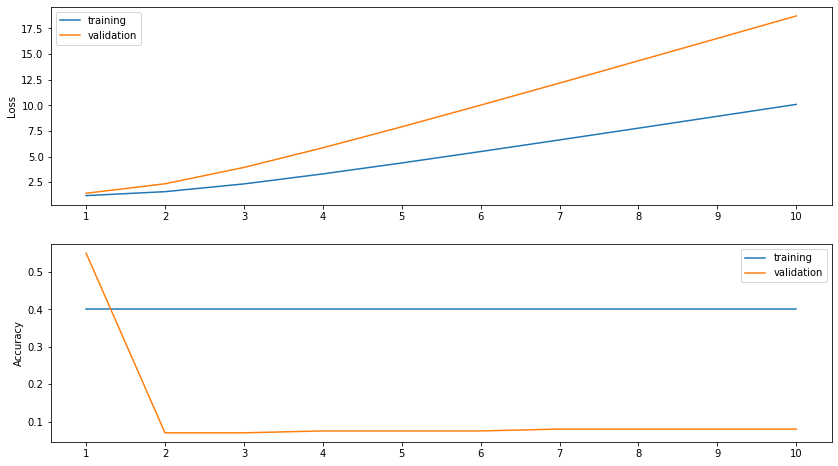

In [37]:
# Vérification: Vous devez pouvoir faire du surapprentissage sur quelques échantillons.
# Si l'accuracy reste faible, votre implémentation a un bogue.
n_check = 5
X_check = X_train[:n_check]
y_check = y_train[:n_check]
model = LinearClassifier(X_check, y_check, X_val, y_val, num_classes=3, bias=True)
loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=10, lr=1.0, l2_reg=0.0)
accu_train_finale = accu_train_curve[-1]
print('Accuracy d\'entraînement, devrait être 1.0: {:.3f}'.format(accu_train_finale))
if accu_train_finale < 0.9999:
    print('ATTENTION: L\'accuracy n\'est pas 100%.')
    utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve)
else:
    print('SUCCÈS')

W = [[ 0.01111373 -0.00104714 -0.00090918]
 [ 0.00050757  0.00287834 -0.00272418]
 [-0.00612996  0.00348354 -0.0102054 ]]
x = [0.63714205 0.67788111 1.        ]
y_n = [ 0.00129513  0.00476754 -0.01263134]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [0.33448748 0.33565098 0.32986154]
loss = 1.0916834112091036
dW = [[ 0.21311604  0.22674275  0.33448748]
 [-0.4232847  -0.45034965 -0.66434902]
 [ 0.21016866  0.22360691  0.32986154]] 
--------
W = [[-0.20200231 -0.22778989 -0.33539666]
 [ 0.42379226  0.453228    0.66162484]
 [-0.21629861 -0.22012336 -0.34006694]]
x = [0.26669239 0.63932783 1.        ]
y_n = [ 0.00077109  0.00888808 -0.0065195 ]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [0.33323493 0.3359508  0.33081428]
loss = 1.09079057100219
dW = [[ 0.08887122  0.21304636  0.33323493]
 [-0.17709687 -0.42454513 -0.6640492 ]
 [ 0.08822565  0.21149877  0.33081428]] 
--------
W = [[-0.29087353 -0.44083625 -0.66863159]
 [ 0.60088913  0.87777313  1.32567404]
 [-0.30452426 -0.43162214 -0.67088121]]
x = [-

 [ 0.22617784 -0.52647702 -0.58783794]] 
--------
W = [[-0.5407061  -0.65656887 -0.83503646]
 [ 2.08354315  1.25642636  1.30996422]
 [-1.53734571 -0.59454274 -0.48876652]]
x = [-0.42868076 -0.6738262   1.        ]
y_n = [-2.70950138 -1.15969731 -1.01349067]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [0.08958405 0.42198991 0.48842603]
loss = 2.4125779394852014
dW = [[ 0.3902778   0.61346212 -0.91041595]
 [-0.18089896 -0.28434786  0.42198991]
 [-0.20937884 -0.32911426  0.48842603]] 
--------
W = [[-0.5407061  -0.65656887 -0.83503646]
 [ 2.08354315  1.25642636  1.30996422]
 [-1.53734571 -0.59454274 -0.48876652]]
x = [1.12003095 0.88025348 1.        ]
y_n = [-0.30890718 -0.22394652 -0.27093263]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [0.31975657 0.34811074 0.33213268]
loss = 1.055234627013622
dW = [[ 0.35813726  0.28146684  0.31975657]
 [-0.73013614 -0.57382779 -0.65188926]
 [ 0.37199889  0.29236095  0.33213268]] 
--------
W = [[-0.5407061  -0.65656887 -0.83503646]
 [ 2.08354315  1.25642636  1.30

W = [[-1.02064022 -1.44559983 -0.77233918]
 [ 4.43875415  2.64212696  2.23597838]
 [-3.41262259 -1.19121239 -1.47747796]]
x = [-0.95010977 -0.41104431  1.        ]
y_n = [-4.26742697 -0.90376512 -1.66275714]
y = 2 | y_1hot = [0. 0. 1.]
softmax = [0.02303003 0.66544829 0.31152167]
loss = 1.166286361142574
dW = [[-0.02188106 -0.00946636  0.02303003]
 [-0.63224892 -0.27352873  0.66544829]
 [ 0.65412998  0.2829951  -0.68847833]] 
--------
W = [[-1.02064022 -1.44559983 -0.77233918]
 [ 4.43875415  2.64212696  2.23597838]
 [-3.41262259 -1.19121239 -1.47747796]]
x = [-0.06652513 -0.11870623  1.        ]
y_n = [-3.87163211 -1.40868059 -1.69152254]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [0.04632485 0.54382641 0.40984873]
loss = 3.0720766996964617
dW = [[ 0.06344337  0.11320718 -0.95367515]
 [-0.03617813 -0.06455558  0.54382641]
 [-0.02726524 -0.0486516   0.40984873]] 
--------
W = [[-1.02064022 -1.44559983 -0.77233918]
 [ 4.43875415  2.64212696  2.23597838]
 [-3.41262259 -1.19121239 -1.47747796]]

--------
W = [[-1.46118436 -2.2651576  -0.23632961]
 [ 7.09944813  4.06548959  2.74172661]
 [-5.63277243 -1.79501725 -2.51923575]]
x = [-0.12627813  0.755549    1.        ]
y_n = [-0.08427589  1.5626992  -0.4178837 ]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [0.14476834 0.75152908 0.10370258]
loss = 0.2856453770214433
dW = [[-0.01828107  0.10937957  0.14476834]
 [ 0.03137644 -0.18773196 -0.24847092]
 [-0.01309537  0.07835238  0.10370258]] 
--------
W = [[-1.46118436 -2.2651576  -0.23632961]
 [ 7.09944813  4.06548959  2.74172661]
 [-5.63277243 -1.79501725 -2.51923575]]
x = [-0.59819419  0.87049821  1.        ]
y_n = [1.42135643 3.09898826 0.00880335]
y = 2 | y_1hot = [0. 0. 1.]
softmax = [0.15159818 0.81148451 0.0369173 ]
loss = 3.299074883888464
dW = [[-0.09068515  0.13196594  0.15159818]
 [-0.48542532  0.70639582  0.81148451]
 [ 0.57611047 -0.83836176 -0.9630827 ]] 
--------
W = [[-1.46118436 -2.2651576  -0.23632961]
 [ 7.09944813  4.06548959  2.74172661]
 [-5.63277243 -1.79501725 -2.5192

 [-0.46264974 -0.86834568  0.50064804]] 
--------
W = [[-1.85866269 -3.02397199  0.49501057]
 [ 9.81188074  5.39383048  2.90973194]
 [-7.94772672 -2.36454374 -3.41858127]]
x = [-0.86905399  0.24108261  1.        ]
y_n = [-3.96697467  1.56380992 -3.1472864 ]
y = 2 | y_1hot = [0. 0. 1.]
softmax = [0.00391219 0.98720797 0.00887985]
loss = 4.723970877036514
dW = [[-3.39990030e-03  9.43159856e-04  3.91218536e-03]
 [-8.57937024e-01  2.37998673e-01  9.87207967e-01]
 [ 8.61336924e-01 -2.38941833e-01 -9.91120152e-01]] 
--------
W = [[-1.85866269 -3.02397199  0.49501057]
 [ 9.81188074  5.39383048  2.90973194]
 [-7.94772672 -2.36454374 -3.41858127]]
x = [1.53258932 0.95483022 1.        ]
y_n = [-1.42761304 -1.84885857  0.11836664]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [0.15751019 0.10336275 0.73912706]
loss = 2.269510652555538
dW = [[ 0.24139844  0.15039549  0.15751019]
 [-1.37417668 -0.85613635 -0.89663725]
 [ 1.13277824  0.70574086  0.73912706]] 
--------
W = [[-1.85866269 -3.02397199  0.495010

 [ 0.395989   -1.54268715 -0.99997193]] 
--------
W = [[ -2.21161748  -3.71672625   1.33645891]
 [ 12.47531066   6.59520618   2.86009664]
 [-10.25820184  -2.87316519  -4.21039431]]
x = [1.56029916 0.45305447 1.        ]
y_n = [-8.05699141 -5.68438234 -0.82933902]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [7.20092007e-04 7.72323089e-03 9.91556677e-01]
loss = 4.863522492892482
dW = [[ 1.12355895e-03  3.26240906e-04  7.20092007e-04]
 [-1.54824861e+00 -4.49555430e-01 -9.92276769e-01]
 [ 1.54712505e+00  4.49229189e-01  9.91556677e-01]] 
--------
W = [[ -2.21161748  -3.71672625   1.33645891]
 [ 12.47531066   6.59520618   2.86009664]
 [-10.25820184  -2.87316519  -4.21039431]]
x = [-0.89711899  0.59724445  1.        ]
y_n = [-0.82330771  4.40013082 -3.70118012]
y = 2 | y_1hot = [0. 0. 1.]
softmax = [5.35826901e-03 9.94340305e-01 3.01425787e-04]
loss = 8.10698671647336
dW = [[-0.004807    0.0032002   0.00535827]
 [-0.89204157  0.59386423  0.99434031]
 [ 0.89684858 -0.59706443 -0.99969857]] 
-------

 [ 0.09308012 -1.73851787 -0.99999946]] 
--------
W = [[ -2.53344631  -4.36446278   2.24692222]
 [ 15.08126326   7.69138854   2.67374947]
 [-12.54232561  -3.32161102  -4.93451045]]
x = [-0.86962688 -1.76952453  1.        ]
y_n = [-37.02583787 -13.13625757 -11.61975967]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [7.58762824e-12 1.79977801e-01 8.20022199e-01]
loss = 25.604502058055942
dW = [[ 0.86962688  1.76952453 -1.        ]
 [-0.15651353 -0.31847513  0.1799778 ]
 [-0.71311334 -1.4510494   0.8200222 ]] 
--------
W = [[ -2.53344631  -4.36446278   2.24692222]
 [ 15.08126326   7.69138854   2.67374947]
 [-12.54232561  -3.32161102  -4.93451045]]
x = [-0.31053521  0.68324937  1.        ]
y_n = [-1.45133773  3.28884472 -3.80542128]
y = 2 | y_1hot = [0. 0. 1.]
softmax = [8.65425757e-03 9.90523757e-01 8.21985811e-04]
loss = 7.103787425119213
dW = [[-0.00268745  0.00591302  0.00865426]
 [-0.3075925   0.67677473  0.99052376]
 [ 0.31027996 -0.68268775 -0.99917801]] 
--------
W = [[ -2.53344631  -4.364

W = [[ -2.83621124  -4.9854391    3.19794535]
 [ 17.63943569   8.71029707   2.40223576]
 [-14.79773311  -3.71954322  -5.61401986]]
x = [0.01258704 0.0823776  1.        ]
y_n = [-13.38033825  -3.06476179  -5.37587677]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [3.01253267e-05 9.09765996e-01 9.02038791e-02]
loss = 10.410144320586886
dW = [[-0.01258666 -0.08237512 -0.99996987]
 [ 0.01145126  0.07494434  0.909766  ]
 [ 0.0011354   0.00743078  0.09020388]] 
--------
W = [[ -2.83621124  -4.9854391    3.19794535]
 [ 17.63943569   8.71029707   2.40223576]
 [-14.79773311  -3.71954322  -5.61401986]]
x = [-0.6678326  -0.06713893  1.        ]
y_n = [-14.08791157  -0.97490446  -7.91099555]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [2.01683580e-06 9.99026867e-01 9.71115942e-04]
loss = 0.0009736065786425231
dW = [[-1.34690869e-06 -1.35408191e-07  2.01683580e-06]
 [ 6.49889793e-04  6.53350906e-05 -9.73132778e-04]
 [-6.48542884e-04 -6.51996824e-05  9.71115942e-04]] 
--------
W = [[ -2.83621124  -4.9854391    3.

 [ 0.17360254  0.18470274  0.2724707 ]] 
--------
W = [[ -2.84788625  -4.99786061   3.17962132]
 [ 17.82471324   8.90742132   2.69303049]
 [-14.97133565  -3.90424596  -5.88649056]]
x = [0.26669239 0.63932783 1.        ]
y_n = [-4.33501009  0.45762494 -3.31678043]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [0.00803942 0.96970514 0.02225544]
loss = 0.03076323810605751
dW = [[ 0.00214405  0.00513983  0.00803942]
 [-0.00807941 -0.01936835 -0.03029486]
 [ 0.00593536  0.01422852  0.02225544]] 
--------
W = [[ -2.8500303   -5.00300044   3.1715819 ]
 [ 17.83279265   8.92678967   2.72332535]
 [-14.97727101  -3.91847449  -5.90874601]]
x = [-0.27791558 -0.58843937  1.        ]
y_n = [-24.67872037  -7.78093715  -8.39268989]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [2.97296055e-08 6.48340502e-01 3.51659468e-01]
loss = 17.331122470309527
dW = [[ 0.27791558  0.58843935 -0.99999997]
 [-0.18018393 -0.38150907  0.6483405 ]
 [-0.09773165 -0.20693027  0.35165947]] 
--------
W = [[ -3.12794588  -5.59143979   4.171

W = [[ -3.12794579  -5.59143975   4.17158175]
 [ 20.15993611   9.67360322   2.07524763]
 [-17.02649899  -4.07684872  -6.26066814]]
x = [-0.32214246  1.34222903  1.        ]
y_n = [11.04039669 10.7085825  -4.81905411]
y = 2 | y_1hot = [0. 0. 1.]
softmax = [5.82200688e-01 4.17799236e-01 7.54051043e-08]
loss = 16.40039086801663
dW = [[-0.18755156  0.78144667  0.58220069]
 [-0.13459087  0.56078226  0.41779924]
 [ 0.32214243 -1.34222893 -0.99999992]] 
--------
W = [[ -3.12794579  -5.59143975   4.17158175]
 [ 20.15993611   9.67360322   2.07524763]
 [-17.02649899  -4.07684872  -6.26066814]]
x = [-0.82939255 -1.46897873  1.        ]
y_n = [-44.04672136 -13.64966762 -12.76904156]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [1.84359765e-14 2.93048062e-01 7.06951938e-01]
loss = 31.624472394188427
dW = [[ 0.82939255  1.46897873 -1.        ]
 [-0.24305188 -0.43048137  0.29304806]
 [-0.58634067 -1.03849736  0.70695194]] 
--------
W = [[ -3.12794579  -5.59143975   4.17158175]
 [ 20.15993611   9.67360322   

W = [[ -3.41347441  -6.18929363   5.15748331]
 [ 22.65031048  10.59576364   1.70906152]
 [-19.23134474  -4.40115526  -6.88038358]]
x = [-0.12207551  0.6427688   1.        ]
y_n = [-4.25573023  3.1650322  -6.41145458]
y = 2 | y_1hot = [0. 0. 1.]
softmax = [5.98292832e-04 9.99332413e-01 6.92938370e-05]
loss = 9.57715458836653
dW = [[-7.30369041e-05  3.84563965e-04  5.98292832e-04]
 [-1.21994017e-01  6.42339695e-01  9.99332413e-01]
 [ 1.22067054e-01 -6.42724259e-01 -9.99930706e-01]] 
--------
W = [[ -3.41347441  -6.18929363   5.15748331]
 [ 22.65031048  10.59576364   1.70906152]
 [-19.23134474  -4.40115526  -6.88038358]]
x = [-0.6330588  -0.75253402  1.        ]
y_n = [-34.11554398  -8.45664111 -11.43150069]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [6.83683022e-12 9.51425357e-01 4.85746434e-02]
loss = 25.708696909325052
dW = [[ 0.6330588   0.75253402 -1.        ]
 [-0.60230819 -0.71597995  0.95142536]
 [-0.03075061 -0.03655407  0.04857464]] 
--------
W = [[ -3.41347441  -6.18929363   5.15748

--------
W = [[ -3.69556132  -6.78276934   6.14995806]
 [ 25.11584968  11.48599869   1.31281198]
 [-21.41479703  -4.6979146   -7.47660879]]
x = [0.03581343 0.82074417 1.        ]
y_n = [-0.93346057  4.48623763 -6.17887494]
y = 1 | y_1hot = [0. 1. 0.]
softmax = [4.40885550e-03 9.95567903e-01 2.32418851e-05]
loss = 0.004441948242252092
dW = [[ 1.57896230e-04  3.61854244e-03  4.40885550e-03]
 [-1.58728601e-04 -3.63761808e-03 -4.43209738e-03]
 [ 8.32371582e-07  1.90756416e-05  2.32418851e-05]] 
--------
W = [[ -3.69556132  -6.78276934   6.14995806]
 [ 25.11584968  11.48599869   1.31281198]
 [-21.41479703  -4.6979146   -7.47660879]]
x = [-0.81459039 -1.37638488  1.        ]
y_n = [-52.97350404 -14.98189079 -14.29324009]
y = 0 | y_1hot = [1. 0. 0.]
softmax = [1.05835567e-17 3.34333300e-01 6.65666700e-01]
loss = 39.08723013034922
dW = [[ 0.81459039  1.37638488 -1.        ]
 [-0.27234469 -0.4601713   0.3343333 ]
 [-0.5422457  -0.91621358  0.6656667 ]] 
--------
W = [[ -3.69556132  -6.78276934 

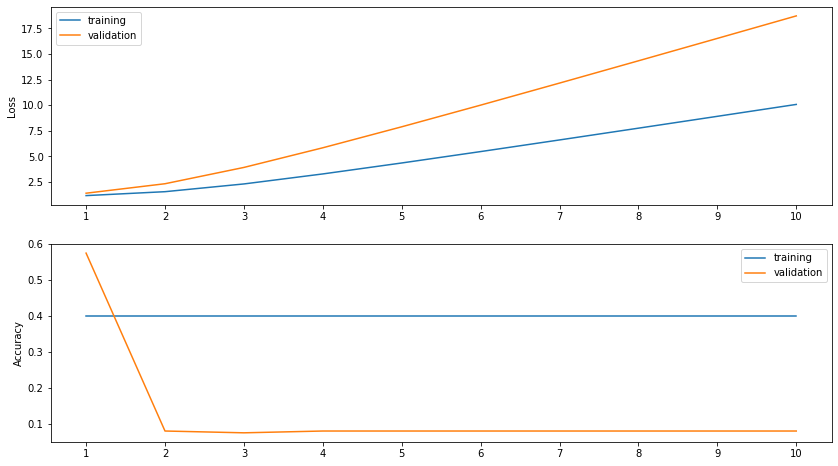

In [36]:
# Vérification: Vous devez pouvoir faire du surapprentissage sur quelques échantillons.
# Si l'accuracy reste faible, votre implémentation a un bogue.
n_check = 5
X_check = X_train[:n_check]
y_check = y_train[:n_check]
model = LinearClassifier(X_check, y_check, X_val, y_val, num_classes=3, bias=True)
loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=10, lr=1.0, l2_reg=0.0)
accu_train_finale = accu_train_curve[-1]
print('Accuracy d\'entraînement, devrait être 1.0: {:.3f}'.format(accu_train_finale))
if accu_train_finale < 0.9999:
    print('ATTENTION: L\'accuracy n\'est pas 100%.')
    utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve)
else:
    print('SUCCÈS')

In [34]:
np.linalg.norm(np.matrix([[3,3,3],[3,3,3],[3,3,3]]))

9.0

In [21]:
# Prenons encore un petit échantillon et testons différentes valeurs de l2_reg
n_check = 5
X_check = X_train[:n_check]
y_check = y_train[:n_check]
model = LinearClassifier(X_check, y_check, X_val, y_val, num_classes=3, bias=True)

for l2_r in np.arange(0,1,0.05):
    loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=10, lr=1.0, l2_reg=l2_r)
    print('l2_reg= {:.4f} >> Loss/accuracy d\'entraînement : {:.3f} {:.3f}'.format(l2_r, loss_train_curve[-1], accu_train_curve[-1]))


l2_reg= 0.0000 >> Loss/accuracy d'entraînement : 11.206 0.200
l2_reg= 0.0500 >> Loss/accuracy d'entraînement : 11.202 0.200
l2_reg= 0.1000 >> Loss/accuracy d'entraînement : 11.192 0.200
l2_reg= 0.1500 >> Loss/accuracy d'entraînement : 11.212 0.200
l2_reg= 0.2000 >> Loss/accuracy d'entraînement : 11.213 0.200
l2_reg= 0.2500 >> Loss/accuracy d'entraînement : 11.153 0.200
l2_reg= 0.3000 >> Loss/accuracy d'entraînement : 11.239 0.200
l2_reg= 0.3500 >> Loss/accuracy d'entraînement : 11.143 0.200
l2_reg= 0.4000 >> Loss/accuracy d'entraînement : 11.199 0.200
l2_reg= 0.4500 >> Loss/accuracy d'entraînement : 11.198 0.200
l2_reg= 0.5000 >> Loss/accuracy d'entraînement : 11.093 0.200
l2_reg= 0.5500 >> Loss/accuracy d'entraînement : 11.168 0.200
l2_reg= 0.6000 >> Loss/accuracy d'entraînement : 11.171 0.200
l2_reg= 0.6500 >> Loss/accuracy d'entraînement : 11.202 0.200
l2_reg= 0.7000 >> Loss/accuracy d'entraînement : 11.171 0.200
l2_reg= 0.7500 >> Loss/accuracy d'entraînement : 11.220 0.200
l2_reg= 

# Vous pouvez maintenant essayer d'entraîner le modèle avec les données complètes

Normalement la loss devrait décroitre et l'accuracy augmenter en fonction des epochs

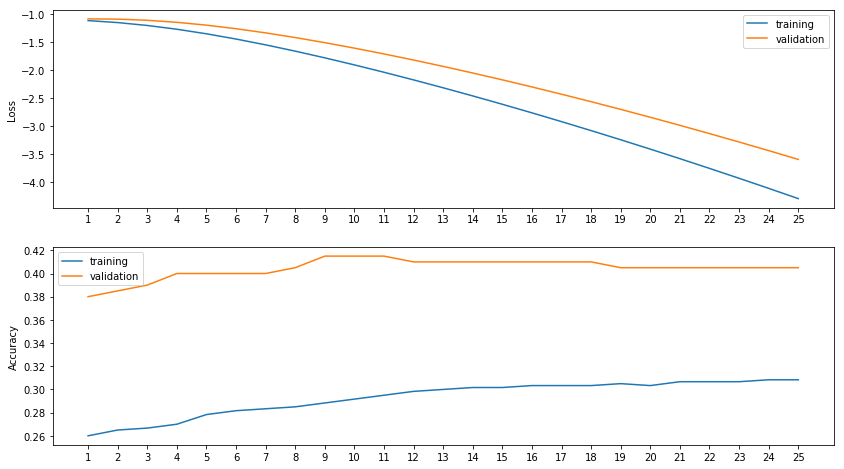

[Training]   Loss: -4.287   Accuracy: 0.308
[Validation] Loss: -3.589   Accuracy: 0.405


In [12]:
# On instancie et entraîne notre modèle; cette fois-ci avec les données complètes.
model = LinearClassifier(X_train, y_train, X_val, y_val, num_classes=3, bias=True)
loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(lr=0.001,num_epochs=25, l2_reg=0.01)

# Illustration de la loss et de l'accuracy (le % de biens classés) à chaque itération     
utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve)

print('[Training]   Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_train_curve[-1], accu_train_curve[-1]))
print('[Validation] Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_val_curve[-1], accu_val_curve[-1]))

# Rechercher de meilleurs hyperparamètres

Nous allons effectuer une recherche sur ces hyperparamètres:

* `learning rate`: La longueur des pas lors de la descente de gradient
* `L2 regularization`: La pénalité sur la taille des poids dans `W`

Best val accuracy: 0.425 | lr: 1e-02 | l2_reg: 1e-01
Best val accuracy: 0.430 | lr: 1e-02 | l2_reg: 1e-02


/home/seb/IFT712_TP/TP4/prog/linear_classifier.py:170: RuntimeWarning: invalid value encountered in true_divide
  d_loss  = -y_1hot / softmax


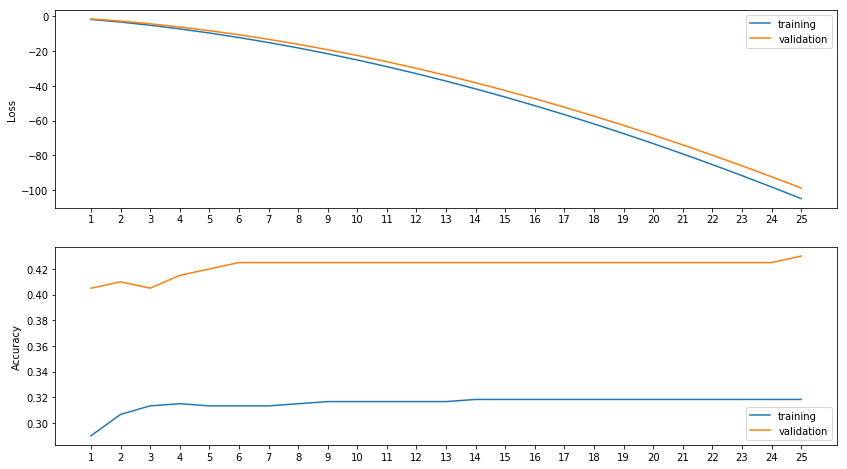

In [13]:
lr_choices = [1e-2, 1e-1, 1.0, 10.0]
reg_choices = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
lr_decay = 0.995  # learning rate is multiplied by this factor after each step

best_accu = -1
best_params = None
best_model = None
best_curves = None

for lr, reg in itertools.product(lr_choices, reg_choices):
    params = (lr, reg)
    curves = model.train(num_epochs=25, lr=lr, l2_reg=reg, lr_decay=lr_decay)
    loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = curves
    
    val_accu = accu_val_curve[-1]
    if val_accu > best_accu:
        print('Best val accuracy: {:.3f} | lr: {:.0e} | l2_reg: {:.0e}'.format(val_accu, lr, reg))
        best_accu = val_accu
        best_params = params
        best_model = model
        best_curves = curves
        
model = best_model
utils.plot_curves(*best_curves)

# Vérifier la généralisation sur l'ensemble de test

In [14]:
# On ré-entraîne le modèle avec les meilleurs hyper-paramètres
lr, reg = best_params
model.train(num_epochs=25, lr=lr, l2_reg=reg, lr_decay=lr_decay)

pred = model.predict(X_test)
accu = (pred == y_test).mean()
print('Test accuracy: {:.3f}'.format(accu))

Test accuracy: 0.335


# Tracer les frontières de décision

Nous allons créer une grille de points 2D qui recouvre les données, et nous allons prédire la classe pour chacun de ces points dans l'espace. Cela nous permettra de visualiser les frontières de décision apprises. 

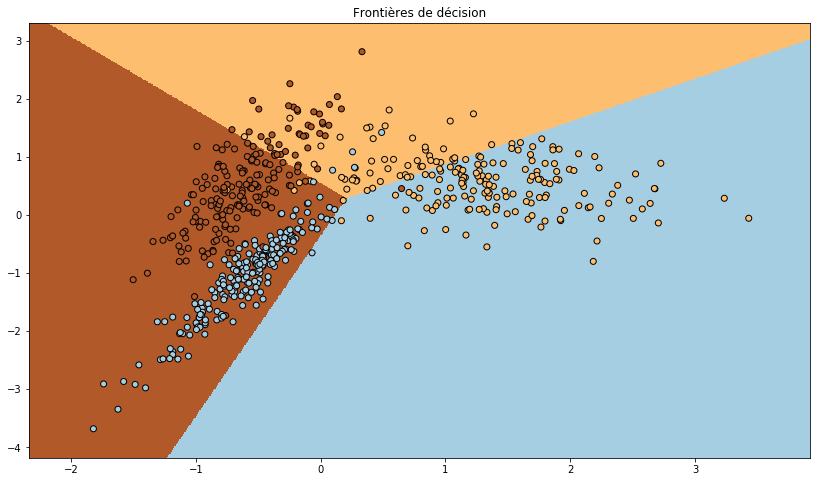

In [15]:
h = 0.01  # contrôle la résolution de la grille
x_min, x_max = X_[:, 0].min() - .5, X_[:, 0].max() + .5  # Limites de la grille
y_min, y_max = X_[:, 1].min() - .5, X_[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Créer la grille

X_predict = np.c_[xx.ravel(), yy.ravel()]  # Convertir la grille en une liste de points
Z = model.predict(X_predict)  # Classifier chaque point de la grille
Z = Z.reshape(xx.shape)  # Remettre en 2D

plt.figure(figsize=(14, 8))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)  # Colorier les cases selon les prédictions

X_plot, y_plot = X_train, y_train
X_plot, y_plot = X_train, y_train
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolors='k', cmap=plt.cm.Paired)  # Tracer les données

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Frontières de décision')
plt.show()

# 2e partie du devoir: la classification non-linéaire

Nous essaierons maintenant d'apprendre des frontières de décision **non-linéaires**.

In [16]:
#Choisissez le type de données que vous voulez 

# NOTE IMPORTANTE: on vous encourage à tester différentes bases de données.  Ceci dit, 
# votre solution sera testée avec Ncircles (N=4).  Vous devez donc tester cette option.
dataset_type = 'Ncircles'
if dataset_type == 'moons':
    X_, y_ = sklearn.datasets.make_moons(n_samples=200, noise=0.5)
    num_classes = 2
elif dataset_type == 'gaussian_quantiles':
    X_, y_ = sklearn.datasets.make_gaussian_quantiles(n_samples=200, n_classes=2)
    num_classes = 2
elif dataset_type == '4blobs':
    d = 4
    c1a = np.random.randn(50, 2)
    c1b = np.random.randn(50, 2) + (d, d)
    c2a = np.random.randn(50, 2) + (0, d)
    c2b = np.random.randn(50, 2) + (d, 0)
    X_ = np.concatenate([c1a, c1b, c2a, c2b], axis=0)
    y_ = np.array([0] * 100 + [1] * 100)
    num_classes = 2
elif dataset_type == '2circles':
    X_, y_ = sklearn.datasets.make_circles(n_samples=200)
    num_classes = 2
elif dataset_type == 'Ncircles':
    samples_per_class = 100
    num_classes = 4
    angles = np.linspace(0, 2*np.pi, samples_per_class)
    radius = 1.0 + np.arange(num_classes) * 0.3
    px = np.cos(angles[:, None]) * radius[None, :]  # (100, 3)
    py = np.sin(angles[:, None]) * radius[None, :]  # (100, 3)
    X_ = np.stack([px, py], axis=-1).reshape((samples_per_class * num_classes, 2))
    X_ += np.random.randn(len(X_[:, 0]),2)/8
    y_ = np.array(list(range(num_classes)) * samples_per_class)
else:
    print('Invalid dataset type')

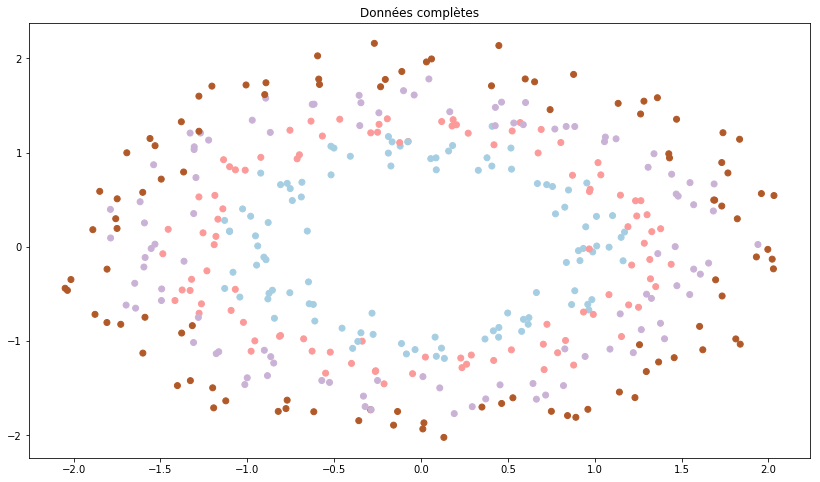

In [20]:
plt.figure(facecolor='w')
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap=plt.cm.Paired)
plt.title('Données complètes')

plt.show()

In [21]:
train_proportion = 0.5
val_proportion = 0.2
num_train = int(len(X_) * train_proportion)
num_val = int(len(X_) * val_proportion)

np.random.seed(0)
idx = np.random.permutation(len(X_))

train_idx = idx[:num_train]
val_idx = idx[num_train:num_train + num_val]
test_idx = idx[num_train + num_val:]

X_train = X_[train_idx]
y_train = y_[train_idx]
X_val = X_[val_idx]
y_val = y_[val_idx]
X_test = X_[test_idx]
y_test = y_[test_idx]

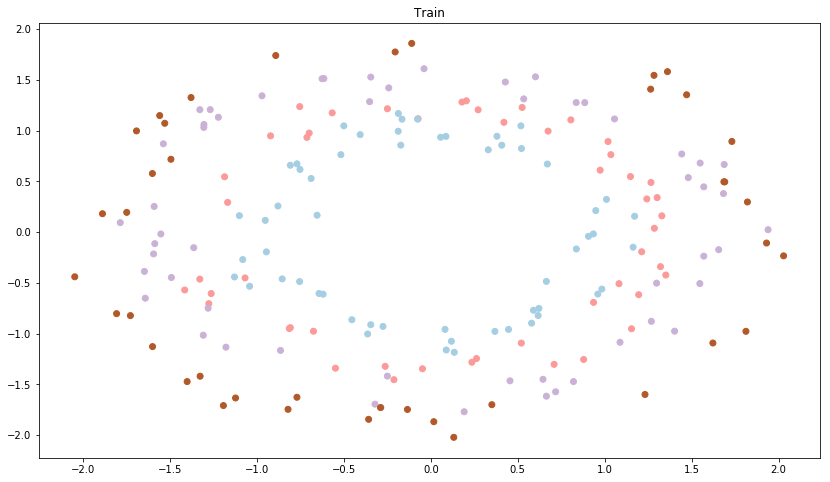

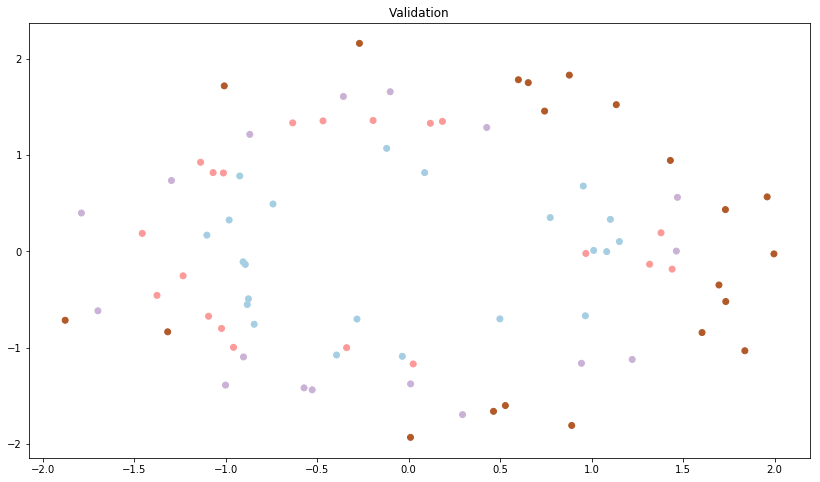

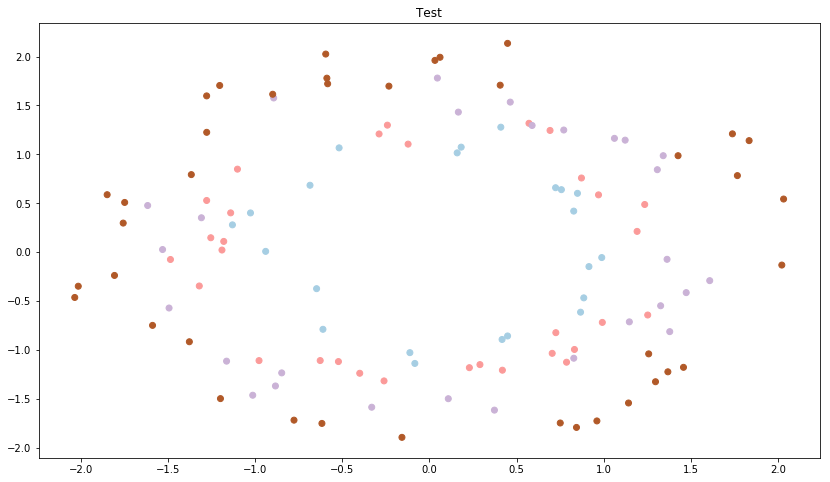

In [22]:
# Affichons maintenant les données d'entraînement, de validation et de test.
plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired)
plt.title('Train')
plt.show()

plt.figure()
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=plt.cm.Paired)
plt.title('Validation')
plt.show()

plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired)
plt.title('Test')
plt.show()

# Entraîner avec la descente de gradient

Dans `two_layer_classifyer.py`, complétez les méthodes avec l'indicatif `TODO`.

Commençons avec quelques **Sanity checks**

In [24]:
num_hidden_neurons = 10
model = TwoLayerClassifier(X_train, y_train, X_val, y_val,
                           num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes)

In [25]:
# Vérifier que la sortie du réseau initialisé au hasard donne bien une prédiction égale pour chaque classe
num_hidden_neurons = 10
model = TwoLayerClassifier(X_train, y_train, X_val, y_val,
                           num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes)

# 2. Appeler la fonction qui calcule l'accuracy et la loss moyenne pour l'ensemble des données d'entraînement
_, loss = model.global_accuracy_and_cross_entropy_loss(X_train,y_train,0)

# 3. Comparer au résultat attendu
loss_attendu = -np.log(1.0/num_classes) # résultat aléatoire attendu soit -log(1/nb_classes)
print('Sortie: {}  Attendu: {}'.format(loss, loss_attendu))
if abs(loss - loss_attendu) > 0.05:
    print('ERREUR: la sortie de la fonction est incorrecte.')
else:
    print('SUCCÈS')

Sortie: 0  Attendu: 1.3862943611198906
ERREUR: la sortie de la fonction est incorrecte.


In [ ]:
# Vérifier que le fait d'augmenter la régularisation L2 augmente également la loss
for l2_r in np.arange(0,2,0.1):
    _, loss = model.global_accuracy_and_cross_entropy_loss(X_train,y_train, l2_r)
    print('l2_reg= {:.4f} >> Loss/accuracy d\'entraînement : {:.3f}'.format(l2_r,loss))

In [ ]:
# Vérification: Vous devez pouvoir faire du surapprentissage sur quelques échantillons.
# Si l'accuracy reste faible, votre implémentation a un bogue.
n_check = 5
X_check = X_train[:n_check]
y_check = y_train[:n_check]
model = TwoLayerClassifier( X_check, y_check, X_val, y_val,
    num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes
)

loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=0.01, l2_reg=0.0)
print('Accuracy d\'entraînement, devrait être 1.0: {:.3f}'.format(accu_train_curve[-1]))
if accu_train_curve[-1] < 0.98:
    print('ATTENTION: L\'accuracy n\'est pas 100%.')
    utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve)
else:
    print('SUCCÈS')

In [ ]:
# Vérifier que le fait d'entraîner avec une régularisation L2 croissante augmente la loss et, éventuellement, diminue l'accuracy
for l2_r in np.arange(0,1,0.1):
    loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=0.01, l2_reg=l2_r)
    print('l2_reg= {:.4f} >> Loss/accuracy d\'entraînement : {:.3f} {:.3f}'.format(l2_r,loss_train_curve[-1],accu_train_curve[-1]))


## Let's train!

In [ ]:
# On instancie notre modèle; cette fois-ci avec les données complètes.
num_hidden_neurons = 20
model = TwoLayerClassifier(X_train, y_train, X_val, y_val, num_features=2, 
                           num_hidden_neurons=num_hidden_neurons, num_classes=num_classes, activation='relu')

In [ ]:
loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=1e-2, l2_reg=0.0,
                                                                                 momentum=0.5)

# Illustration de la loss et de l'accuracy (le % de biens classés) à chaque itération     
utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve)

print('[Training]   Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_train_curve[-1], accu_train_curve[-1]))
print('[Validation] Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_val_curve[-1], accu_val_curve[-1]))

In [ ]:
# Find the best hyperparameters lr and l2_reg
lr_choices = [1e-4, 1e-3, 1e-2]
reg_choices = [1e-1, 1e-2, 1e-3, 1e-4, 0]
lr_decay = 1.0  # 0.995  # learning rate is multiplied by this factor after each step

best_accu = -1
best_params = None
best_model = None
best_curves = None

for lr, reg in itertools.product(lr_choices, reg_choices):
    params = (lr, reg)
    curves = model.train(num_epochs=50, lr=lr, l2_reg=reg, lr_decay=lr_decay,momentum=0.5)
    loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = curves
    
    val_accu = accu_val_curve[-1]
    if val_accu > best_accu:
        print('Best val accuracy: {:.3f} | lr: {:.0e} | l2_reg: {:.0e}'.format(val_accu, lr, reg))
        best_accu = val_accu
        best_params = params
        best_model = model
        best_curves = curves
    else:
        print('accuracy: {:.3f} | lr: {:.0e} | l2_reg: {:.0e}'.format(val_accu, lr, reg))
        
model = best_model
utils.plot_curves(*best_curves)

In [ ]:
# On ré-entraîne le modèle avec les meilleurs hyper-paramètres
lr, reg = best_params
print(best_params)
curves = model.train(num_epochs=200, lr=lr, l2_reg=reg,momentum=0.5)
loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = curves

pred = model.predict(X_test)
accu = (pred == y_test).mean()
print('Test accuracy: {:.3f}'.format(accu))
utils.plot_curves(*curves)

# Tracer les frontières de décision

Nous allons créer une grille de points 2D qui recouvre les données, et nous allons prédire la classe pour chacun de ces points dans l'espace. Cela nous permettra de visualiser les frontières de décision apprises. 

In [ ]:
# Visualisation des résultats

h = 0.05  # contrôle la résolution de la grille
x_min, x_max = X_[:, 0].min() - .5, X_[:, 0].max() + .5  # Limites de la grille
y_min, y_max = X_[:, 1].min() - .5, X_[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Créer la grille

X_predict = np.c_[xx.ravel(), yy.ravel()]  # Convertir la grille en une liste de points
Z = model.predict(X_predict)  # Classifier chaque point de la grille
Z = Z.reshape(xx.shape)  # Remettre en 2D

plt.figure(figsize=(14, 8))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)  # Colorier les cases selon les prédictions

X_plot, y_plot = X_, y_
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolors='k', cmap=plt.cm.Paired)  # Tracer les données

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.title('Frontières de décision')
plt.show()